<a href="https://colab.research.google.com/github/MDankloff/ScriptAIRbnb.R/blob/main/testCOMPAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [26]:
#using a simplified subset from COMPAS obtained from kaggle (Ofer, 2017)
cdata = pd.read_csv("/content/propublica_data_for_fairml.csv")
cdata.head()
cdata.info
display(cdata.columns)


Index(['Two_yr_Recidivism', 'Number_of_Priors', 'score_factor',
       'Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'African_American',
       'Asian', 'Hispanic', 'Native_American', 'Other', 'Female',
       'Misdemeanor'],
      dtype='object')

# preprocessing Compas Data

In [27]:
target = "Two_yr_Recidivism"
X = cdata.drop([target], axis= 1)
Y = cdata[target]


In [28]:
len(cdata)

6172

In [29]:
#split test train set - stratify=y ensures that the distribution of classes in the target variable y is maintained in both the training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.3, shuffle =True, stratify = Y)

In [30]:
# Train random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

In [31]:
# Predict
Y_hat = rf.predict(X_test)
len(Y_hat)

1852

In [32]:
# Store and convert predicted and true classes (np) in a data frame

Predictions_col = pd.DataFrame() #Create empty data frame


Predictions_col ['predicted_class'] = Y_hat.tolist() # Add column named 'predicted_class' to Predictions_col with values from Y_hat, converted to a list


Predictions_col = Predictions_col.set_index(X_test.index) # Sets the index of Predictions_col to be the same as the index of X_test. This aligns the predicted classes with the corresponding samples in the test set

Predictions_col['true_class'] = Y_test #Add column named 'true_class' to Outcome with the true classes from y_test


In [33]:
Predictions_col['errors'] = abs(Predictions_col['predicted_class'] - Predictions_col['true_class']) #Calculating the erros by subtracting the true class values from the predicted class values


In [34]:
#Rescaling the errors so it can be used as a clustering attribute - Max error value of 1 - doesnt matter if its between class 0 and 2 or 0 and 1
Predictions_col['errors'] = Predictions_col['errors'].replace(2.0, 1.0)
#print(len(Outcome['errors']))

In [35]:
# Merging the X_test DataFrame with the Predictions_col DataFrame using the common index
Final_cdata = X_test.merge(Predictions_col, how= 'outer', left_index = True, right_index = True)
errors = Final_cdata['errors']

df_out = Final_cdata.drop(['predicted_class', 'true_class', 'errors'], axis=1) # Extract the 'errors' column and create the final dataset (df_out) by dropping the columns related to Predictions_col

#Prints length of the entire dataset and displays rows where the error is equal to 1
print (len(Final_cdata))
Final_cdata[Final_cdata['errors']==1]


1852


,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor,predicted_class,true_class,errors
5395,2,1,0,0,0,0,0,0,0,0,0,1,0,1
4327,0,0,0,1,1,0,0,0,0,0,0,0,1,1
3221,4,1,0,0,1,0,0,0,0,0,0,1,0,1
4829,1,1,0,0,1,0,0,0,0,0,1,1,0,1
454,20,1,0,0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801,2,1,0,1,0,0,1,0,0,0,0,1,0,1
2294,1,0,0,1,1,0,0,0,0,0,1,1,0,1
3915,1,0,1,0,0,0,1,0,0,0,0,0,1,1
3600,4,1,0,0,1,0,0,0,0,0,0,1,0,1


In [36]:
errors = len(Final_cdata.loc[Final_cdata['errors']==1])
correct = len(Final_cdata.loc[Final_cdata['errors']==0])
print (correct)
print (errors)

print(accuracy_score(Y_test, Y_hat))

1193
659
0.6441684665226782


In [37]:
if 'decile_score' in cdata.columns:
    print("Column 'decile_score' exists.")
else:
    print("Column 'decile_score' does not exist.")

Column 'decile_score' does not exist.


In [39]:
# Grouping by 'decile_score' and calculating the mean of 'two_year_recid' for each group
# Define decile_score first - not found in Selmas code


# adding Decile_rank column to the DataFrame -
cdata['decile_score'] = pd.qcut(cdata['Two_yr_Recidivism'], 10, labels = False, duplicates = 'drop')

# printing the DataFrame
print(cdata)

      Two_yr_Recidivism  Number_of_Priors  score_factor  Age_Above_FourtyFive  \
0                     0                 0             0                     1   
1                     1                 0             0                     0   
2                     1                 4             0                     0   
3                     0                 0             0                     0   
4                     1                14             1                     0   
...                 ...               ...           ...                   ...   
6167                  0                 0             1                     0   
6168                  0                 0             0                     0   
6169                  0                 0             0                     1   
6170                  0                 3             0                     0   
6171                  1                 2             0                     0   

      Age_Below_TwentyFive 

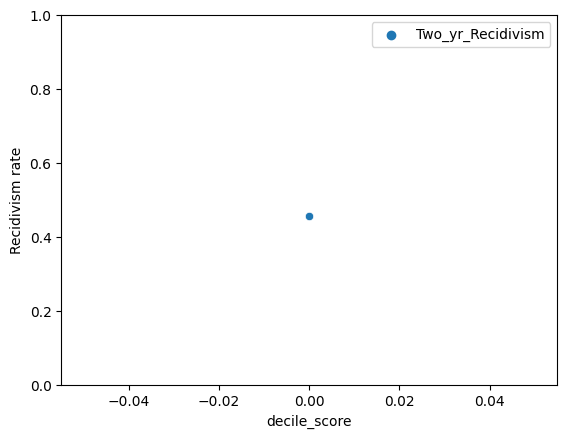

In [40]:
d = cdata.groupby('decile_score').agg({'Two_yr_Recidivism': 'mean'})

# Creating a scatter plot
sns.scatterplot(data=d)
plt.ylim(0, 1)  # Setting y-axis limits
plt.ylabel('Recidivism rate')  # Labeling the y-axis
plt.show()  # Display the plot how the mean 'two_year_recid' changes across different decile scores. The scatter plot allows you to observe patterns or trends in the recidivism rate as a function of the decile scores